# Storm Indices

In [1]:
import storm_indices as si

import numpy as np
import pandas as pd
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import shapefile as shp
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import reshape_as_image
import glob as gl
from datetime import datetime, date, time, timedelta
import calendar
import os
import warnings
warnings.filterwarnings('ignore')

### Read McMurdo Ice Data

In [2]:
path = '../Data/ice'
# create list of file names
flight_files = gl.glob(path + "/*.csv")
# create data frame
columns = ['Year', 'Month', 'Day', 'Ice Fraction']
content = []
for filename in tqdm.tqdm(flight_files, total=len(flight_files)):
    df = pd.read_csv(filename, names=columns, header=0, sep=',')
    content.append(df)
ICE = pd.concat(content)
ICE['DateTime'] = pd.to_datetime(ICE[['Year', 'Month', 'Day']])
ICE.set_index('DateTime', inplace=True)
ICE = ICE[['Ice Fraction']]

ICE

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.54it/s]


,Ice Fraction
DateTime,
2019-01-01,0.410753
2019-01-02,0.396774
2019-01-03,0.416129
2019-01-04,0.421505
2019-01-05,0.384946
...,...
2024-12-27,0.540860
2024-12-28,0.605376
2024-12-29,0.688172


### Read in Temperature and Pressure Data

In [68]:
station_name = 'ScottBase'
#station_name = 'Vito'
#station_name = 'Margaret'
#station_name = 'Ferrell'
#station_name = 'MarblePoint'
#station_name = 'CapeBird'
#station_name = 'Manuela'
#station_name = 'Alessandra'
#station_name = 'Silvia'

In [69]:
if station_name == 'ScottBase':
    # SCOTT BASE
    t_column_name = 'Mean Temperature [Deg C]'
    p_column_name = 'Mean sea level pressure [Hpa]'
    TP = pd.read_csv('../Data/scottbase/scottbase.csv')
    TP['DateTime'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
    TP.index = TP['DateTime']
    del TP['DateTime']
elif station_name in ['Alessandra', 'Silvia']:
    if station_name == 'Alessandra':
        TP = pd.read_csv('../Data/alessandra/alessandra.csv')
    elif station_name == 'Silvia':
        TP = pd.read_csv('../Data/silvia/silvia.csv')
    t_column_name = 'temperature_C'
    p_column_name = 'pressure_hPa'
    TP['DateTime'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
    TP.index = TP['DateTime']
    del TP['DateTime']
else:
    # AMRC AWS: VITO, MARBLEPOINT, MANUELA, PHOENIX, FERRELL, WHITLOCK, POSSESSIONISLAND, CAPEBIRD, MARGARET, GILL
    if station_name == 'Vito':
        TP = pd.read_csv('../Data/vito/vito.csv')
    elif station_name == 'MarblePoint':
        TP = pd.read_csv('../Data/marblePoint/marblePoint.csv')
    elif station_name == 'Manuela':
        TP = pd.read_csv('../Data/manuela/manuela.csv')
    elif station_name == 'Ferrell':
        TP = pd.read_csv('../Data/ferrell/ferrell.csv')
    elif station_name == 'CapeBird':
        TP = pd.read_csv('../Data/capebird/capebird.csv')
    elif station_name == 'Margaret':
        TP = pd.read_csv('../Data/margaret/margaret.csv')
    t_column_name = 'temperature'
    p_column_name = 'pressure'
    TP['DateTime'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
    TP.index = TP['DateTime']
    del TP['DateTime']

In [70]:
TP = TP[[t_column_name, p_column_name]]
TP = TP[~TP.index.isna()]

TP

,Mean Temperature [Deg C],Mean sea level pressure [Hpa]
DateTime,,
1964-09-30,NaN,1005.0
1964-10-01,-24.6,997.6
1964-10-02,-25.8,997.4
1964-10-03,-28.3,989.1
1964-10-04,-26.2,976.2
...,...,...
2025-05-10,-19.6,995.9
2025-05-11,-26.0,1001.5
2025-05-12,-28.8,1003.4


### Compute Storm Index

In [71]:
TP = si.compute_si(TP, t_column_name, p_column_name, 'SI')
TP

,Mean Temperature [Deg C],Mean sea level pressure [Hpa],SI
DateTime,,,
1964-09-30,NaN,1005.0,0.000000
1964-10-01,-24.6,997.6,0.000000
1964-10-02,-25.8,997.4,0.000000
1964-10-03,-28.3,989.1,0.300536
1964-10-04,-26.2,976.2,0.300536
...,...,...,...
2025-05-10,-19.6,995.9,0.000000
2025-05-11,-26.0,1001.5,0.000000
2025-05-12,-28.8,1003.4,0.000000


### Add Ice Fraction

In [72]:
TP = TP.join(ICE, how='outer')
TP.loc['2019-01-01':'2024-12-31']

,Mean Temperature [Deg C],Mean sea level pressure [Hpa],SI,Ice Fraction
DateTime,,,,
2019-01-01,0.1,983.5,0.030238,0.410753
2019-01-02,-3.2,979.8,0.103032,0.396774
2019-01-03,-3.5,978.0,0.103032,0.416129
2019-01-04,-2.6,975.6,0.072794,0.421505
2019-01-05,-2.4,984.0,0.000000,0.384946
...,...,...,...,...
2024-12-27,-3.4,989.1,0.000000,0.540860
2024-12-28,-4.7,993.9,0.000000,0.605376
2024-12-29,-2.9,989.5,0.000000,0.688172


### Prepare Second Dataframe with years split into columns (helpful for plotting)

In [73]:
df = TP.copy()

df['month_day'] = df.index.strftime('%m-%d')
df['year'] = df.index.year

# Create a new DataFrame with desired structure
TP_plot = pd.concat([
    df.pivot(index='month_day', columns='year', values=t_column_name).add_prefix('T'),
    df.pivot(index='month_day', columns='year', values=p_column_name).add_prefix('P'),
    df.pivot(index='month_day', columns='year', values='SI').add_prefix('SI'),
    df.pivot(index='month_day', columns='year', values='Ice Fraction').add_prefix('ICE')
], axis=1)

TP_plot

year,T1964,T1965,T1966,T1967,T1968,T1969,T1970,T1971,T1972,T1973,...,ICE2016,ICE2017,ICE2018,ICE2019,ICE2020,ICE2021,ICE2022,ICE2023,ICE2024,ICE2025
month_day,,,,,,,,,,,,,,,,,,,,,
01-01,NaN,-4.5,-1.8,-2.0,-1.3,-1.7,-1.1,0.4,-2.0,-4.3,...,NaN,NaN,NaN,0.410753,0.509677,0.434409,0.678495,0.826882,0.776344,NaN
01-02,NaN,-4.4,-2.4,-2.3,-3.2,-6.2,-2.1,1.3,-2.7,-6.3,...,NaN,NaN,NaN,0.396774,0.508602,0.412903,0.695699,0.808602,0.733333,NaN
01-03,NaN,-2.0,-3.7,-3.6,-4.6,-6.4,-4.2,1.5,-1.4,-8.1,...,NaN,NaN,NaN,0.416129,0.509677,0.411828,0.710753,0.798925,0.623656,NaN
01-04,NaN,-7.3,-4.2,0.2,-2.7,-6.1,-4.0,1.4,-1.6,-9.6,...,NaN,NaN,NaN,0.421505,0.598925,0.404301,0.772043,0.817204,0.589247,NaN
01-05,NaN,-3.8,-3.9,1.3,-2.7,-7.7,-2.0,-0.5,-6.5,-10.6,...,NaN,NaN,NaN,0.384946,0.532258,0.396774,0.776344,0.830108,0.569892,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-27,-3.9,-2.4,-2.8,-3.0,-2.0,-2.9,-6.0,-3.7,-3.3,-3.9,...,NaN,NaN,NaN,0.498925,0.427957,0.704301,0.770968,0.741935,0.540860,NaN
12-28,-0.5,-3.6,-5.0,-8.1,-0.5,-1.3,-8.3,-6.5,-4.9,-2.6,...,NaN,NaN,NaN,0.522581,0.447312,0.693548,0.862366,0.740860,0.605376,NaN
12-29,-0.3,-0.7,-5.4,-3.6,-2.0,-0.4,-4.8,-4.5,-6.0,-2.6,...,NaN,NaN,NaN,0.506452,0.437634,0.682796,0.853763,0.747312,0.688172,NaN


In [74]:
ice2019 = TP_plot['ICE2019']
ice2020 = TP_plot['ICE2020']
ice2021 = TP_plot['ICE2021']
ice2022 = TP_plot['ICE2022']
ice2023 = TP_plot['ICE2023']
ice2024 = TP_plot['ICE2024']

In [75]:
if station_name == 'ScottBase':
    # SCOTT BASE
    sb2019 = TP_plot['SI2019']
    sb2020 = TP_plot['SI2020']
    sb2021 = TP_plot['SI2021']
    sb2022 = TP_plot['SI2022']
    sb2023 = TP_plot['SI2023']
    sb2024 = TP_plot['SI2024']
else:
    # AMRC AWS: MARBLEPOINT, MANUELA, MARGARET, VITO
    if station_name == 'MarblePoint':
        mp2019 = TP_plot['SI2019']
        mp2020 = TP_plot['SI2020']
        mp2021 = TP_plot['SI2021']
        mp2022 = TP_plot['SI2022']
        mp2023 = TP_plot['SI2023']
        mp2024 = TP_plot['SI2024']
    elif station_name == 'Manuela':
        mn2019 = TP_plot['SI2019']
        mn2020 = TP_plot['SI2020']
        mn2021 = TP_plot['SI2021']
        mn2022 = TP_plot['SI2022']
        mn2023 = TP_plot['SI2023']
        mn2024 = TP_plot['SI2024']
    elif station_name == 'Margaret':
        mr2019 = TP_plot['SI2019']
        mr2020 = TP_plot['SI2020']
        mr2021 = TP_plot['SI2021']
        mr2022 = TP_plot['SI2022']
        mr2023 = TP_plot['SI2023']
        mr2024 = TP_plot['SI2024']
    elif station_name == 'Ferrell':
        fl2019 = TP_plot['SI2019']
        fl2020 = TP_plot['SI2020']
        fl2021 = TP_plot['SI2021']
        fl2022 = TP_plot['SI2022']
        fl2023 = TP_plot['SI2023']
        fl2024 = TP_plot['SI2024']
    elif station_name == 'Vito':
        vt2019 = TP_plot['SI2019']
        vt2020 = TP_plot['SI2020']
        vt2021 = TP_plot['SI2021']
        vt2022 = TP_plot['SI2022']
        vt2023 = TP_plot['SI2023']
        vt2024 = TP_plot['SI2024']
    elif station_name == 'Alessandra':
        al2019 = TP_plot['SI2019']
        al2020 = TP_plot['SI2020']
        al2021 = TP_plot['SI2021']
    elif station_name == 'CapeBird':
        cb2019 = TP_plot['SI2019']
        cb2020 = TP_plot['SI2020']
        cb2021 = TP_plot['SI2021']
        cb2022 = TP_plot['SI2022']
        cb2023 = TP_plot['SI2023']
        cb2024 = TP_plot['SI2024']
    elif station_name == 'Silvia':
        si2019 = TP_plot['SI2019']
        si2020 = TP_plot['SI2020']
        si2021 = TP_plot['SI2021']

# Plot

In [76]:
# format x-axis
month_starts = [f'{m}-01' for m in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']]
month_start_positions = [TP_plot.index.get_loc(month_start) for month_start in month_starts]
month_start_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

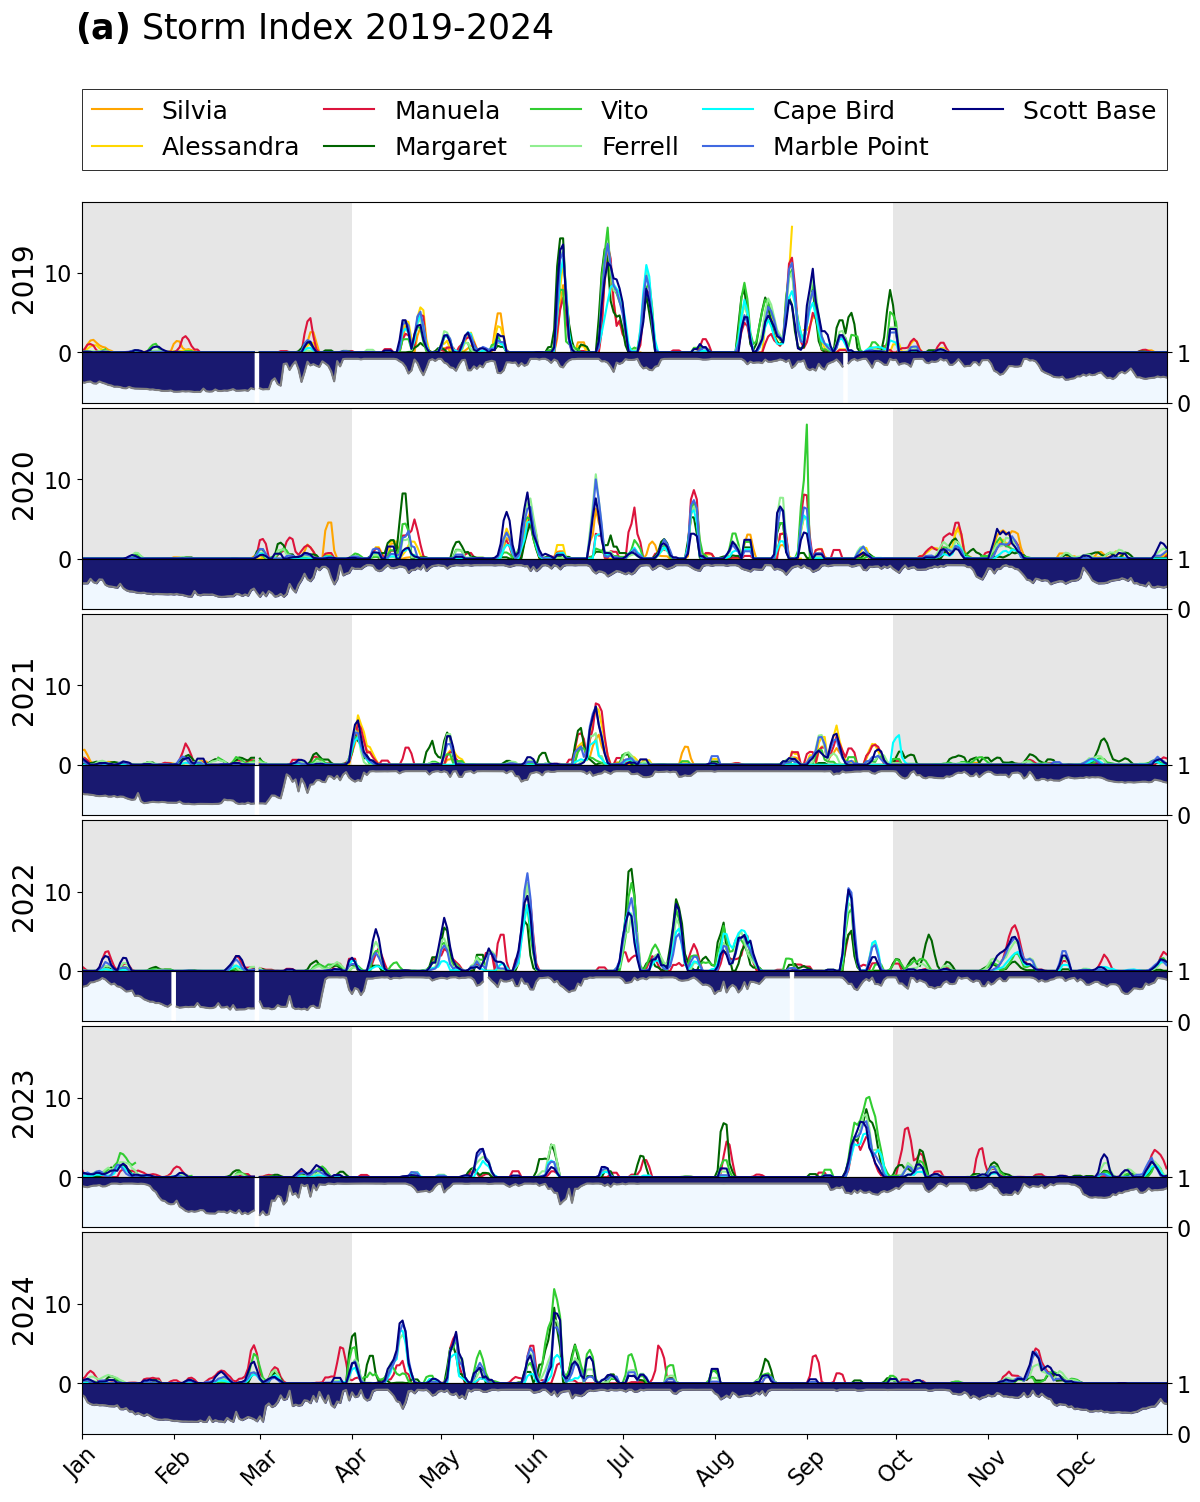

In [84]:
# Updated height ratios: add small blank (0.3) after every 2nd plot (index+ice)
height_ratios = [3, 1, 0.1, 3, 1, 0.1, 3, 1, 0.1, 3, 1, 0.1, 3, 1, 0.1, 3, 1]

fig, ax = plt.subplots(17, 1, figsize=(14, 16), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios})

plt.subplots_adjust(hspace=0.0)
plt.suptitle(r'$\bf{(a)}$ Storm Index 2019-2024', fontsize=25, x=0.12, y=1., ha='left')

year_list = ['2019', '2020', '2021', '2022', '2023', '2024']

for j in range(6):
    base_idx = j * 3  # because every year uses 3 rows now: index, ice, spacer

    # Storm index
    if j < 3:
        ax[base_idx].plot(TP_plot.index, globals()[f"si{year_list[j]}"], label='Silvia', color='orange')
        ax[base_idx].plot(TP_plot.index, globals()[f"al{year_list[j]}"], label='Alessandra', color='gold')
    
    ax[base_idx].plot(TP_plot.index, globals()[f"mn{year_list[j]}"], label='Manuela', color='crimson')
    ax[base_idx].plot(TP_plot.index, globals()[f"mr{year_list[j]}"], label='Margaret', color='darkgreen')
    ax[base_idx].plot(TP_plot.index, globals()[f"vt{year_list[j]}"], label='Vito', color='limegreen')
    ax[base_idx].plot(TP_plot.index, globals()[f"fl{year_list[j]}"], label='Ferrell', color='lightgreen')
    ax[base_idx].plot(TP_plot.index, globals()[f"cb{year_list[j]}"], label='Cape Bird', color='aqua')
    ax[base_idx].plot(TP_plot.index, globals()[f"mp{year_list[j]}"], label='Marble Point', color='royalblue')
    ax[base_idx].plot(TP_plot.index, globals()[f"sb{year_list[j]}"], label='Scott Base', color='navy')

    ax[base_idx].axvspan('01-01', '04-01', facecolor='0.9', zorder=0)
    ax[base_idx].axvspan('09-30', '12-31', facecolor='0.9', zorder=0)
    
    ax[base_idx].set_ylim((0, 19))
    ax[base_idx].set_ylabel(year_list[j], fontsize=20)
    ax[base_idx].tick_params(labelsize=16)
    ax[base_idx].yaxis.set_ticks_position('left')

    # Ice fraction
    ice = globals()[f"ice{year_list[j]}"]
    ax[base_idx + 1].plot(TP_plot.index, ice, color='gray', label='Ice Fraction')
    ax[base_idx + 1].fill_between(TP_plot.index, ice, 0, where=ice < 1, interpolate=True, color='aliceblue')
    ax[base_idx + 1].fill_between(TP_plot.index, ice, 1, where=ice < 1, interpolate=True, color='midnightblue')
    ax[base_idx + 1].set_ylim(0, 1)
    ax[base_idx + 1].tick_params(labelsize=16)
    ax[base_idx + 1].yaxis.set_ticks_position('right')
    ax[base_idx + 1].tick_params(labelright=True)
    ax[base_idx + 1].spines['right'].set_visible(True)

# Hide blank axes
for k in range(2, 17, 3):  # These are the spacer axes
    ax[k].axis('off')

# Set x-axis ticks only on the bottom plot (the last ice plot)
for ax_i in ax[:-1]:
    ax_i.tick_params(labelbottom=False, bottom=False)
ax[-1].set_xticks(ticks=month_start_positions, labels=month_start_labels, rotation=45)
ax[-1].set_xlim(('01-01', '12-31'))

# Legend (same as before)
s = fig.subplotpars
bb = [s.left, s.top + 0.02, s.right - s.left, 0.05]
leg = ax[0].legend(loc=8, bbox_to_anchor=bb, ncol=5, mode="expand", borderaxespad=0,
                   bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", fontsize=18)
leg.get_frame().set_linewidth(72. / fig.dpi)

plt.savefig('../Figures/all_si_and_ice', bbox_inches='tight')
plt.show()